In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import scipy.stats as stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.sm_exceptions import ValueWarning

In [2]:
CAMINHO_RAIZ = os.getcwd()
caminho_dados = os.path.join(CAMINHO_RAIZ, "data", "dengue_pernambuco.xlsx")

In [3]:
dataset = pd.read_excel(caminho_dados)
dataset["semana"] = pd.to_datetime(dataset["semana"])
dataset.set_index("semana", inplace=True)

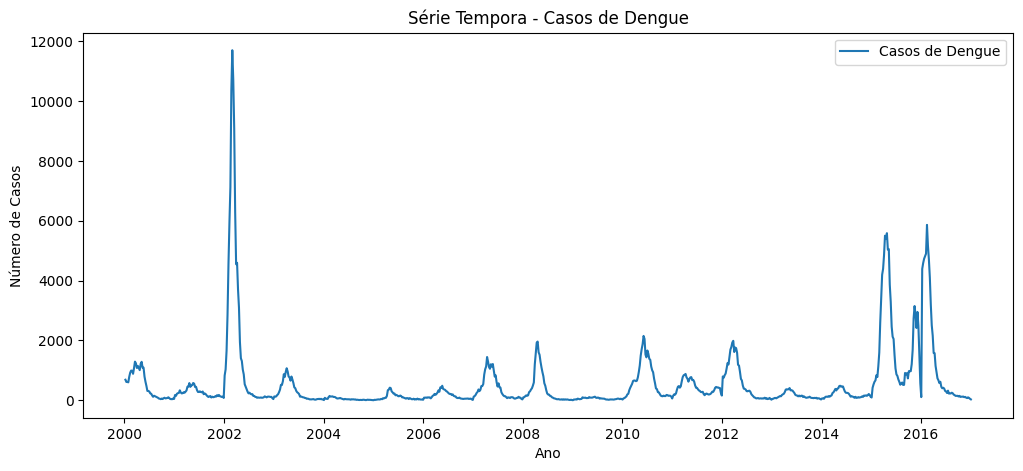

In [4]:
plt.figure(figsize=(12, 5))
plt.plot(dataset.index, dataset["valor"], label="Casos de Dengue")
plt.title("Série Tempora - Casos de Dengue")
plt.xlabel("Ano")
plt.ylabel("Número de Casos")
plt.legend()
plt.show()

In [5]:
resultado_estacionariedade = adfuller(dataset["valor"])
print("Estatística ADF:", resultado_estacionariedade[0])
print("p-valor:", resultado_estacionariedade[1])

Estatística ADF: -5.663070483050537
p-valor: 9.28398959516521e-07


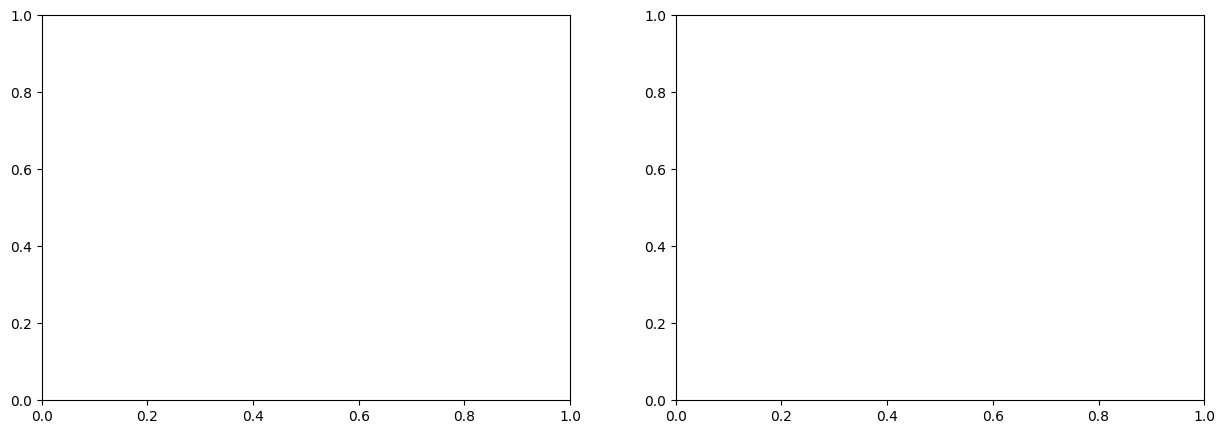

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

In [7]:
best_results = []
p_range = range(0, 4)
d = 0

q_range = range(0, 4)

P_range = range(0, 4)
D = 1
Q_range = range(0, 4)

s=52

In [8]:
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from joblib import Parallel, delayed
import itertools
import numpy as np
import pandas as pd

# >>> ENTRADAS
serie = dataset["valor"].astype(float)
s = 52  # sazonalidade já definida

# melhor atual (para gerar a vizinhança)
p0, d0, q0 = 1, 0, 3
P0, D0, Q0 = 1, 1, 3

# (opcional) usar subset rápido para busca; depois reestimar no full
use_subset = True
subset_len = 6 * s  # ~6 "estações"
y_fit = serie.iloc[-subset_len:] if (use_subset and len(serie) > subset_len) else serie

# Vizinhança: variar em torno do melhor (clamp em [0,4] para segurança)
def hood(v, lo=0, hi=4):
    return sorted(set([max(lo, min(hi, v + d)) for d in (-1, 0, 1)]))

p_grid  = hood(p0, 0, 4)
q_grid  = hood(q0, 0, 4)
P_grid  = hood(P0, 0, 3)
Q_grid  = hood(Q0, 0, 3)
d_grid  = sorted(set([d0, 1]))   # testa d igual ao atual e +1
D_grid  = [D0]                    # mantém D=1
lb_lags = [10, 15, 20]

# heurística simples para evitar modelos "pesados" sem necessidade
def skip(p,q,P,Q):
    if (p+q) > 5: return True
    if (P+Q) > 4: return True
    if p>=3 and q>=3: return True
    if P>=2 and Q>=2: return True
    return False

def eval_model(order, seasonal_order):
    try:
        p,d,q = order
        P,D,Q,s = seasonal_order

        # acelera o ajuste
        model = SARIMAX(
            y_fit,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
            simple_differencing=True,    # costuma acelerar
            concentrate_scale=True
        )
        res = model.fit(disp=False, method="lbfgs", maxiter=150, tol=1e-4)

        # Ljung-Box nos resíduos
        lb = acorr_ljungbox(res.resid, lags=lb_lags, return_df=True)
        lb_pmin = float(lb["lb_pvalue"].min())
        lb_stats = {f"LB_p@{L}": float(lb.loc[L, "lb_pvalue"]) for L in lb_lags}

        return {
            "order": order,
            "seasonal": seasonal_order,
            "aic": float(res.aic),
            "bic": float(res.bic),
            "lb_pmin": lb_pmin,
            **lb_stats
        }
    except Exception as e:
        return None

# gerar candidatos
candidatos = []
for p,q,P,Q,d,D in itertools.product(p_grid, q_grid, P_grid, Q_grid, d_grid, D_grid):
    if skip(p,q,P,Q):
        continue
    # evita redundâncias óbvias: se d=1 e p e q são altos, costuma sobrar correlação
    if d==1 and (p+q)>=6:
        continue
    candidatos.append(((p,d,q),(P,D,Q,s)))

# avaliar em paralelo
best_results = Parallel(n_jobs=-1, verbose=10)(
    delayed(eval_model)(o, so) for (o,so) in candidatos
)

# filtra falhas
best_results = [r for r in best_results if r is not None]

# rank: maior lb_pmin (melhor ruído branco), depois menor AIC
df = pd.DataFrame(best_results)
df = df.sort_values(by=["lb_pmin","aic"], ascending=[False, True]).reset_index(drop=True)

print("\n=== TOP 10 por (Ljung-Box p-min DESC, AIC ASC) ===")
cols_show = ["order","seasonal","aic","bic","lb_pmin"] + [f"LB_p@{L}" for L in lb_lags]
print(df[cols_show].head(10).to_string(index=False))

# reestimar o melhor no FULL para métricas finais
if not df.empty:
    best = df.iloc[0]
    best_order = tuple(best["order"])
    best_seasonal = tuple(best["seasonal"])
    final = SARIMAX(
        serie,
        order=best_order,
        seasonal_order=best_seasonal,
        enforce_stationarity=False,
        enforce_invertibility=False,
        simple_differencing=True,
        concentrate_scale=True
    ).fit(disp=False, method="lbfgs", maxiter=300, tol=1e-5)

    print("\n=== Melhor reestimado na série completa ===")
    print(f"order={best_order}, seasonal={best_seasonal}")
    print(f"AIC={final.aic:.1f} | BIC={final.bic:.1f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.5min


KeyboardInterrupt: 

In [29]:
# Extrair apenas os 4 valores da tupla (sem o modelo em si)
best_order, best_seas, best_aic, best_bic = best_results[0]

# Separar em variáveis individuais
p, d_best, q = best_order
P, D_best, Q, s_best = best_seas

print("=== Melhor modelo por AIC ===")
print(f"p={p}, d={d_best}, q={q}, P={P}, D={D_best}, Q={Q}, s={s_best}")
print(f"AIC={best_aic:.2f}, BIC={best_bic:.2f}")

# Reestimar o melhor modelo na série completa
final_model = SARIMAX(
    serie,
    order=best_order,
    seasonal_order=best_seas,
    enforce_stationarity=False,
    enforce_invertibility=False,
    simple_differencing=True,
    concentrate_scale=True
).fit(disp=False, method="lbfgs", maxiter=300, tol=1e-5)

print("\n=== Usando o modelo final já treinado ===")
best_model = final_model  # esse é o que você deve usar adiante
print(best_model.summary())

=== Melhor modelo por AIC ===
p=1, d=0, q=3, P=1, D=1, Q=3, s=52
AIC=1524.52, BIC=1547.96


C:\Users\Felipe Oliveira\Desktop\CIÊNCIA DE DADOS\SÉRIES TEMPORAIS\PROJETO DA DISCIPLINA\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(


KeyboardInterrupt: 

In [23]:
# 'best_model' já é o objeto resultante (.fit()) do melhor ajuste
print(best_model.summary())  # resumo estatístico do ajuste

                                     SARIMAX Results                                      
Dep. Variable:                         DS52.valor   No. Observations:                  835
Model:             SARIMAX(1, 0, 3)x(1, 0, 3, 52)   Log Likelihood               -4647.694
Date:                            Tue, 30 Sep 2025   AIC                           9313.388
Time:                                    21:35:40   BIC                           9354.020
Sample:                                01-06-2001   HQIC                          9329.121
                                     - 12-31-2016   Scale                         1406.590
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9293      0.010     94.839      0.000       0.910       0.949
ma.L1          0.2601      0.020   

In [24]:
residuos = best_model.resid

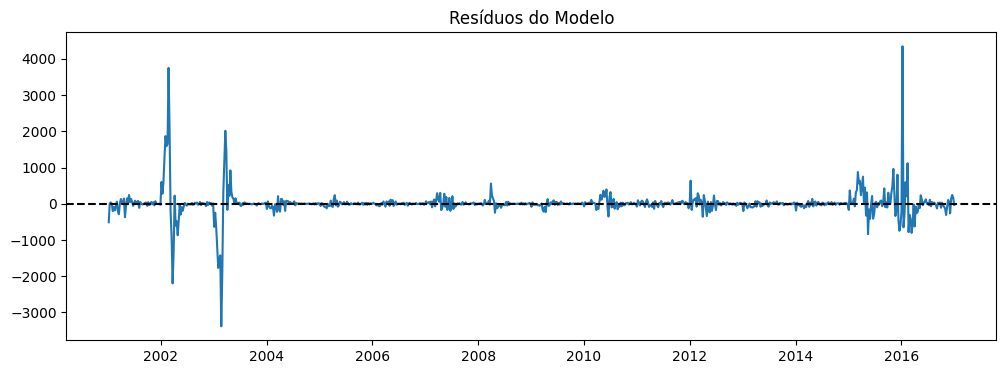

In [25]:
plt.figure(figsize=(12,4))
plt.plot(residuos)
plt.title("Resíduos do Modelo")
plt.axhline(0, color="black", linestyle="--")
plt.show()

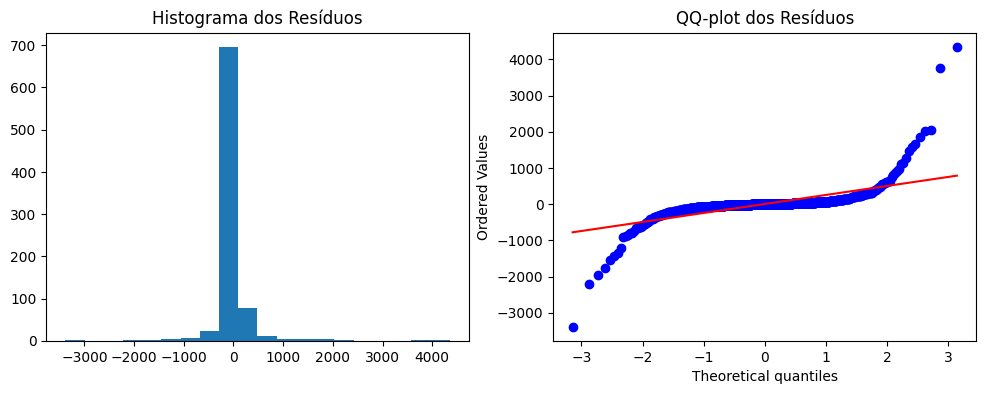

In [26]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(residuos, bins=20)
plt.title("Histograma dos Resíduos")
plt.subplot(1,2,2)
stats.probplot(residuos, dist="norm", plot=plt)  # QQ-plot
plt.title("QQ-plot dos Resíduos")
plt.show()

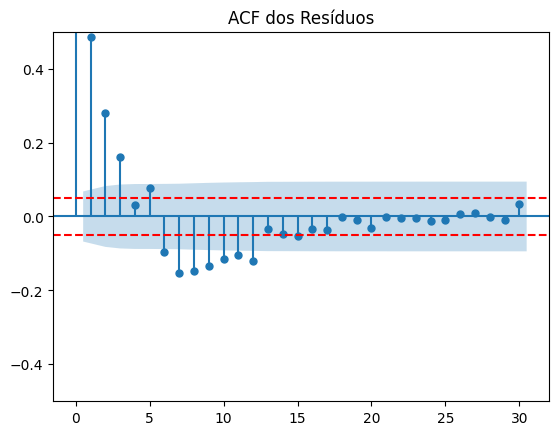

In [27]:
plot_acf(residuos, lags=30)
plt.title("ACF dos Resíduos")

plt.ylim(-0.5, 0.5)

plt.axhline(y=0.05, color='red', linestyle='--')
plt.axhline(y=-0.05, color='red', linestyle='--')

plt.show()

In [19]:
lb_test = acorr_ljungbox(residuos, lags=[10, 15, 20], return_df=True)
print("Ljung-Box test (estatística e p-valor por lag):")
print(lb_test)

Ljung-Box test (estatística e p-valor por lag):
       lb_stat     lb_pvalue
10  361.693415  1.312088e-71
15  388.562405  1.746275e-73
20  391.565414  1.145997e-70
